In [1]:
import os
import numpy as np
import pandas as pd
import thesis.jaxdaw as jd
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import random, vmap
from thesis.glitch import GlitchModel, GlitchPrior, estimate_asy
from thesis.io import fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
data = fgong.load_fgong(filename)
data

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [3]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


In [4]:
names = ["worst", "better", "best"]

obs = {}
v19 = {}
gp = {}
for name in names:
    obs[name] = pd.read_csv(f"data/glitch-inputs-{name}.csv")
    v19[name] = pd.read_csv(f"data/v19-glitch-results-{name}.csv", index_col=0)
    gp[name] = jd.load_results(f"data/gp-glitch-results-{name}.h5")

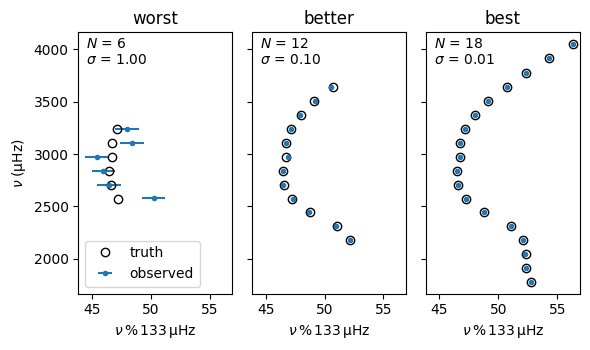

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(6, 3.6), sharey=True, sharex=True, 
                        #  gridspec_kw={"wspace": 0.0}
                        )
delta_nu = 133.0

for i, (k, v) in enumerate(obs.items()):
    ax = axes[i]
    ax.errorbar(v.nu%delta_nu, v.nu, xerr=v.nu_err, fmt=".", label="observed")
    err = v.nu_err.iloc[0]
    ax.text(0.05, 0.88, f"$N$ = {len(v)}\n$\\sigma$ = {err:.2f}", 
            transform=ax.transAxes)
    
    ax.plot(v.nu_true%delta_nu, v.nu_true, "ok", markerfacecolor="none", label="truth")
    ax.set_title(k)
    ax.set_xlabel(f"$\\nu\\,\\% \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")

axes[0].legend(loc="lower left")
axes[0].set_ylabel(r"$\nu\;(\mathrm{\mu Hz})$")
# fig.supxlabel(f"$\\nu\\,\\% \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")
# fig.supylabel(r"$\nu\;(\mathrm{\mu Hz})$")
fig.tight_layout()
fig.savefig("../figures/glitch-test-obs.pdf", format="pdf", dpi=300)

In [6]:
rng = random.PRNGKey(2023)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
shape = (1000,)

gps = {}
for k, v in gp.items():
    rng, key = random.split(rng)
    gps[k] = jd.resample(key, v, shape=shape)

In [8]:
model = {}
for k, v in obs.items():
    n, nu, nu_err = v.n.to_numpy(), v.nu.to_numpy(), v.nu_err.to_numpy()
    args = estimate_asy(n, nu, nu_err)
    prior = GlitchPrior(*args)
    model[k] = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

In [9]:
def _oscillation(nu, tau, phi):
    return np.sin(4 * np.pi * tau * nu + phi)

def poly(p, x):
    powers = np.arange(p.shape[-1])
    return np.sum(p*x[..., None]**powers, axis=-1)

def smooth_component(param, n, npoly_params=5):
    return np.apply_along_axis(
        poly, 
        -1,
        param[..., :npoly_params], 
        n,
    )

def helium_amp(param, nu):
    return param[..., -4, None] * nu * np.exp(- 8e-12 * np.pi**2 * param[..., -3, None]**2 * nu**2)

def helium_glitch(param, nu):
    return helium_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -2, None], param[..., -1, None])

def bcz_amp(param, nu):
    return param[..., -7, None] / nu**2

def bcz_glitch(param, nu):
    return bcz_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -6, None], param[..., -5, None])

def glitch(param, nu):
    return helium_glitch(param, nu) + bcz_glitch(param, nu)

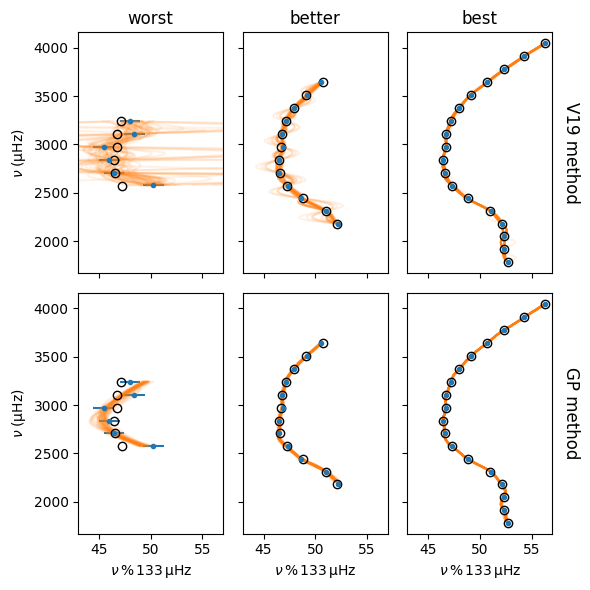

In [10]:
fig, (axtop, axbot) = plt.subplots(2, 3, figsize=(6, 6), sharey=True, sharex=True, 
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
draws = 50

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]
    ax.set_title(k)
    lobs = ax.errorbar(obs[k].nu%delta_nu, obs[k].nu, xerr=obs[k].nu_err, fmt=".", label="observed")

    thin = len(v) // draws
    n_pred = np.linspace(obs[k].n.min(), obs[k].n.max(), 201)
    param = v.iloc[:, :-2].to_numpy()

    nu_pred = smooth_component(param, n_pred)
    nu_pred += glitch(param, nu_pred)
    x = (nu_pred - n_pred * delta_nu) % delta_nu
    ldraw = ax.plot(x[::thin].T, nu_pred[::thin].T, color="C1", alpha=0.1)
    
    ltrue, = ax.plot(obs[k].nu_true%delta_nu, obs[k].nu_true, "ok",
            markerfacecolor="none", label="truth")
#     if i == 0:
#         ax.legend(loc="upper left")

# ax.legend(handles=[lobs, ltrue, ldraw[0]])
ax.yaxis.set_label_position("right")
ax.set_ylabel("V19 method", rotation=270, labelpad=20., fontsize="large")

for i, (k, v) in enumerate(model.items()):
    ax = axbot[i]
    rng, key = random.split(rng)
    v.plot_echelle(key, gps[k], delta_nu=delta_nu, draws=draws, color="C1", alpha=0.1, ax=ax)
    ax.plot(obs[k].nu_true%delta_nu, obs[k].nu_true, "ok", 
            markerfacecolor="none", label="truth")
    ax.set_xlabel(f"$\\nu\\,\\% \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")
    
ax.set_xlim(43, 57)
ax.yaxis.set_label_position("right")
ax.set_ylabel("GP method", rotation=270, labelpad=20., fontsize="large")

axtop[0].set_ylabel(r"$\nu\;(\mathrm{\mu Hz})$")
axbot[0].set_ylabel(r"$\nu\;(\mathrm{\mu Hz})$")

# fig.supxlabel(f"$\\nu\\,\\% \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")
# fig.supylabel(r"$\nu\;(\mathrm{\mu Hz})$")
fig.tight_layout()
fig.savefig("../figures/glitch-test-echelle.pdf", format="pdf", dpi=300)

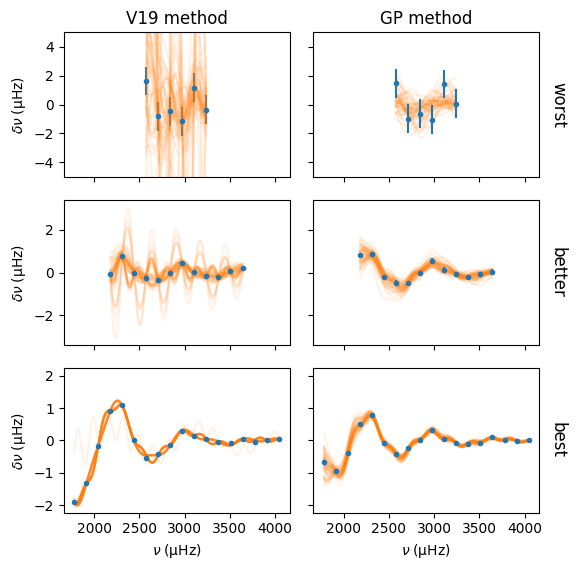

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex=True, 
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]

    thin = len(v) // draws
    nu_pred = np.linspace(obs[k].nu.min(), obs[k].nu.max(), 201)
    param = v.iloc[:, :-2].to_numpy()

    nu_sm = np.median(smooth_component(param, obs[k].n.to_numpy()), axis=0)
    dnu = obs[k].nu.to_numpy() - nu_sm
    ax.errorbar(nu_sm, dnu, yerr=obs[k].nu_err, fmt=".", label="observed")
    
    dnu_pred = glitch(param, nu_pred)
    x = np.broadcast_to(nu_pred, dnu_pred.shape)
    ax.plot(x[::thin].T, dnu_pred[::thin].T, color="C1", alpha=0.1)
    ax.set_ylabel(r"$\delta\nu\;(\mathrm{\mu Hz})$")
    
    ylim = min(5, np.abs(ax.get_ylim()).max())
    ax.set_ylim(-ylim, ylim)
    
    if i == 0:
        ax.set_title("V19 method")
#         ax.legend()

for i, (k, v) in enumerate(model.items()):
    ax = axbot[i]
    if i == 0:
        ax.set_title("GP method")
    v.plot_glitch(gps[k], draws=draws, color="C1", alpha=0.1, ax=ax)

    nu_gp, _ = vmap(lambda x: v.predict(x, v.n, include_mean=False))(gps[k])
    nu_sm = vmap(lambda x: v.smooth_component(x, v.n))(gps[k])
    dnu = v.nu - nu_sm - nu_gp
    ax.errorbar(np.median(nu_sm, axis=0), np.median(dnu, axis=0), yerr=v.nu_err, fmt=".")
    
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(k, rotation=270, labelpad=20., fontsize="large")
    
#     ylim = np.abs(ax.get_ylim()).max()
#     ax.set_ylim(-ylim, ylim)

axtop[-1].set_xlabel(r"$\nu\;(\mathrm{\mu Hz})$")
axbot[-1].set_xlabel(r"$\nu\;(\mathrm{\mu Hz})$")

# fig.supxlabel(r"$\nu\;(\mathrm{\mu Hz})$")
# fig.supylabel(r"$\delta\nu\;(\mathrm{\mu Hz})$")

# ax.set_ylim(-3, 3)
fig.tight_layout()
fig.savefig("../figures/glitch-test-signal.pdf", format="pdf", dpi=300)

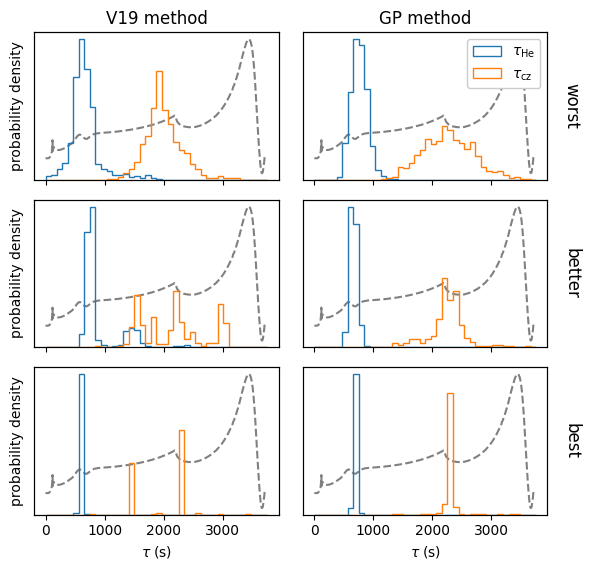

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col", 
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T
rlim = (0, 1e6/2/delta_nu)
bins = 40
alpha = 1
histtype = "step"

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]
       
    ax.plot(data.tau, 1e-5*differentiate(data.cs, data.tau), "--", c="gray")
#     ax.set_ylabel(r"${\mathrm{d}c}\,/\,{\mathrm{d}\tau}\;(\mathrm{km\,s^{-2}})$")
    ax.set_ylabel(r"probability density")

    ax.set_yticks([])
    
    ax = ax.twinx()
    ax.hist(v["tau_he"], bins=bins, range=rlim, alpha=alpha, histtype=histtype)
    ax.hist(v["tau_cz"], bins=bins, range=rlim, alpha=alpha, histtype=histtype)
    ax.set_yticks([]) 
    
    if i == 0:
        ax.set_title("V19 method")


for i, (k, v) in enumerate(model.items()):
    ax = axbot[i]
    ax.plot(data.tau, 1e-5*differentiate(data.cs, data.tau), "--", c="gray")
    ax.set_yticks([])
    
    ax = ax.twinx()
    
    ax.hist(1e6*np.exp(gps[k]["log_tau_he"]), bins=bins, range=rlim, alpha=alpha, 
            label=r"$\tau_\mathrm{He}$", histtype=histtype)
    ax.hist(1e6*np.exp(gps[k]["log_tau_cz"]), bins=bins, range=rlim, alpha=alpha, 
            label=r"$\tau_\mathrm{cz}$", histtype=histtype)
    
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(k, rotation=270, labelpad=20., fontsize="large")
    ax.set_yticks([])
    
    if i == 0:
        ax.set_title("GP method")
        ax.legend(framealpha=1.0)
    
axtop[-1].set_xlabel(r"$\tau\;(\mathrm{s})$")
axbot[-1].set_xlabel(r"$\tau\;(\mathrm{s})$")

# fig.supxlabel(r"$\nu\;(\mathrm{\mu Hz})$")
# fig.supylabel(r"$\delta\nu\;(\mathrm{\mu Hz})$")

# ax.set_ylim(-3, 3)
fig.tight_layout()
fig.savefig("../figures/glitch-test-tau.pdf", format="pdf", dpi=300)

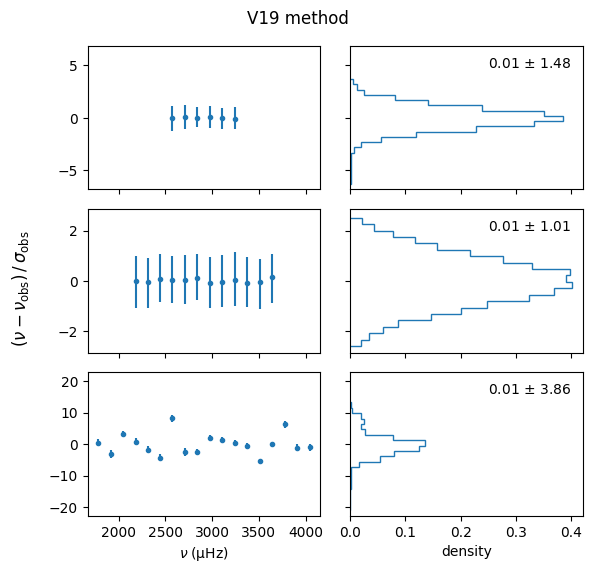

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]

    param = v.iloc[:, :-2].to_numpy()
    nu = smooth_component(param, obs[k].n.to_numpy())
    nu += glitch(param, nu)
    
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    res = (nu - nu_obs) / nu_err
    # res = (nu - nu_true) / nu_err
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    # plt.plot(nu, res, ".C1", alpha=0.1)
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    # break
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()), 
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")

axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.suptitle("V19 method")
fig.supylabel(r"$(\nu - \nu_\mathrm{obs}) \, / \, \sigma_\mathrm{obs}$")
fig.tight_layout()

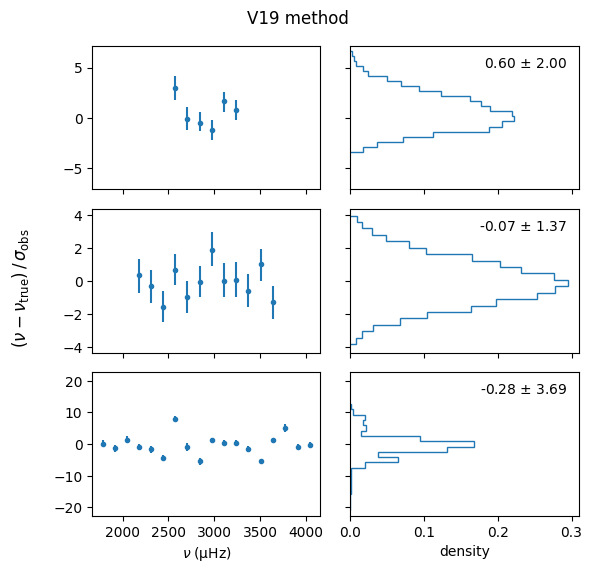

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]

    param = v.iloc[:, :-2].to_numpy()
    nu = smooth_component(param, obs[k].n.to_numpy())
    nu += glitch(param, nu)
    
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    res = (nu - nu_true) / nu_err
    # res = (nu - nu_true) / nu_err
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    # plt.plot(nu, res, ".C1", alpha=0.1)
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    # break
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()), 
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")

axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.suptitle("V19 method")
fig.supylabel(r"$(\nu - \nu_\mathrm{true}) \, / \, \sigma_\mathrm{obs}$")
fig.tight_layout()


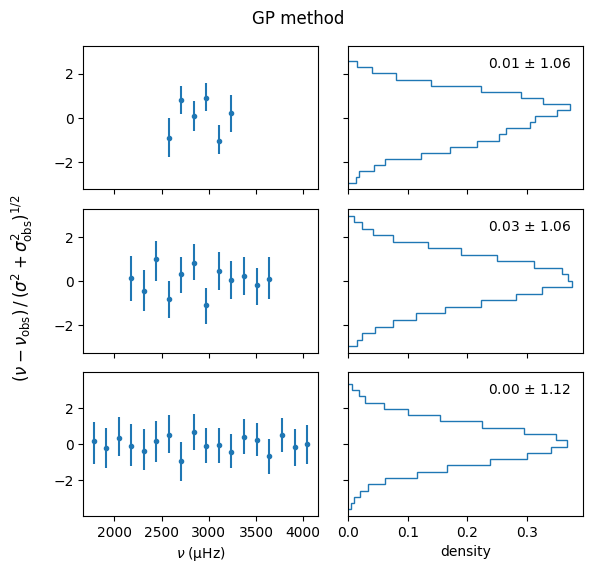

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(model.items()):
    ax = axtop[i]
    
    # nu, nu_var = vmap(lambda x: v.predict(x, v.n))(gps[k])
    keys = random.split(rng, gps[k]["delta_nu"].shape[0])
    nu = vmap(lambda k, x: v.sample(k, x, v.n))(keys, gps[k])
    # Not a great idea to just use nu_var as points are correlated
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    sig2 = np.exp(2*gps[k]["log_sigma"])
    res = (nu - nu_obs) / np.sqrt(sig2[:, None] + nu_err**2)
    # res = (nu - nu_obs) / np.sqrt(nu_var + nu_err**2)
    # res = (nu - nu_true) / np.sqrt(nu_var + nu_err**2)
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    
    # ax.errorbar(nu_true, nu_obs - nu_true, yerr=nu_err, fmt=".")
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()),
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")


axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.supylabel(r"$(\nu - \nu_\mathrm{obs}) \, / \, (\sigma^2 + \sigma_\mathrm{obs}^2)^{1/2}$")


fig.suptitle("GP method")
fig.tight_layout()

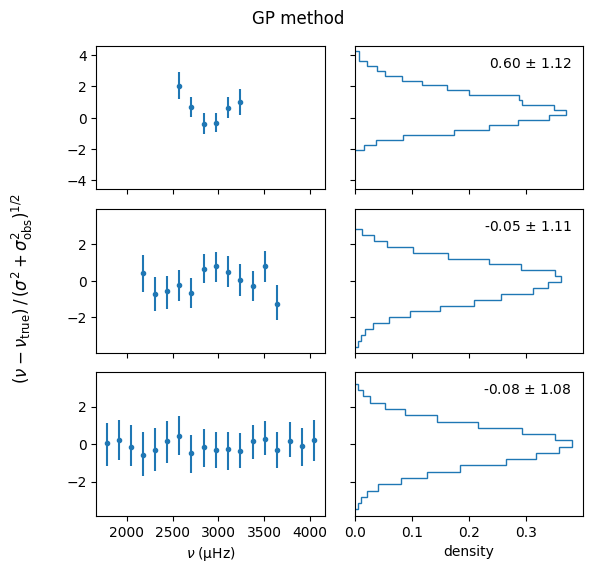

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(model.items()):
    ax = axtop[i]
    
    # nu, nu_var = vmap(lambda x: v.predict(x, v.n))(gps[k])
    keys = random.split(rng, gps[k]["delta_nu"].shape[0])
    nu = vmap(lambda k, x: v.sample(k, x, v.n))(keys, gps[k])
    # Not a great idea to just use nu_var as points are correlated
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    sig2 = np.exp(2*gps[k]["log_sigma"])
    res = (nu - nu_true) / np.sqrt(sig2[:, None] + nu_err**2)
    # res = (nu - nu_obs) / np.sqrt(nu_var + nu_err**2)
    # res = (nu - nu_true) / np.sqrt(nu_var + nu_err**2)
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    
    # ax.errorbar(nu_true, nu_obs - nu_true, yerr=nu_err, fmt=".")
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()),
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")


axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.supylabel(r"$(\nu - \nu_\mathrm{true}) \, / \, (\sigma^2 + \sigma_\mathrm{obs}^2)^{1/2}$")


fig.suptitle("GP method")
fig.tight_layout()

In [17]:
nu_ref = 3000.

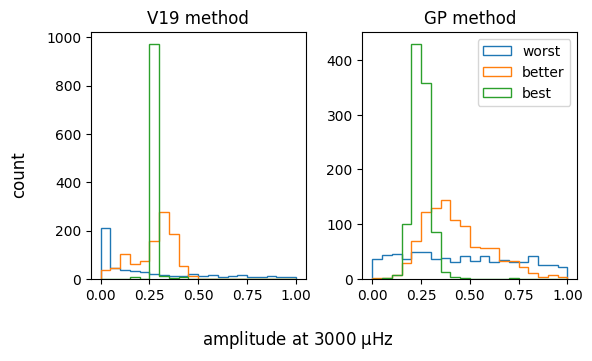

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3.6), sharex=True)

ax = axes[0]
for k, v in v19.items():
    param = v.iloc[:, :-2].to_numpy()
    ahe = helium_amp(param, nu_ref)
    ax.hist(ahe, range=(0, 1), bins=20, histtype="step")
ax.set_title("V19 method")

ax = axes[1]
for k, v in gps.items():
    ahe = model[k].helium_amp(v, nu_ref)
    ax.hist(ahe, range=(0, 1), bins=20, histtype="step", label=k)

ax.legend()
ax.set_title("GP method")

fig.supxlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
fig.supylabel(f"count")

fig.tight_layout()

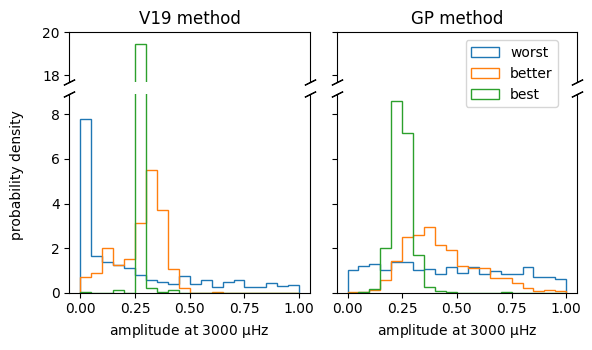

In [33]:
fig, (axtop, axbot) = plt.subplots(2, 2, figsize=(6, 3.6), sharex=True, sharey="row",
                                   gridspec_kw={"height_ratios": [1, 4]})

histtype = "step"
alpha = 1.0
density = True
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
              linestyle="none", color='k', mec='k', mew=0.8, clip_on=False)
    
ax = axbot[0]
axt = axtop[0]
for k, v in v19.items():
    param = v.iloc[:, :-2].to_numpy()
    ahe = helium_amp(param, nu_ref)
#     ax.hist(ahe, range=(0, 1), bins=20, histtype="step")
#     axt.hist(ahe, range=(0, 1), bins=20, histtype="step")
    ax.hist(ahe, range=(0, 1), bins=20, histtype=histtype, alpha=alpha, density=density)
    axt.hist(ahe, range=(0, 1), bins=20, histtype=histtype, alpha=alpha, density=density)
    
    ax.spines['top'].set_visible(False)
    ax.xaxis.tick_bottom()
#     axt.xaxis.tick_top()
    axt.tick_params(labeltop=False, bottom=False)
    axt.spines['bottom'].set_visible(False)
    
    axt.plot([0, 1], [0, 0], transform=axt.transAxes, **kwargs)
    ax.plot([0, 1], [1, 1], transform=ax.transAxes, **kwargs)

ax.set_xlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
# ax.set_ylabel("count")
axt.set_title("V19 method")

ax = axbot[1]
axt = axtop[1]
for k, v in gps.items():
    ahe = model[k].helium_amp(v, nu_ref)
#     ax.hist(ahe, range=(0, 1), bins=20, histtype="step")
    ax.hist(ahe, range=(0, 1), bins=20, histtype=histtype, alpha=alpha,
            density=density, label=k)
#     axt.hist(ahe, range=(0, 1), bins=20, histtype="step", label=k)
    axt.hist(ahe, range=(0, 1), bins=20, histtype=histtype, alpha=alpha, 
             density=density)
    
    ax.spines['top'].set_visible(False)
    ax.xaxis.tick_bottom()
#     axt.tick_params()
    axt.tick_params(labeltop=False, bottom=False)
    axt.spines['bottom'].set_visible(False)
    axt.plot([0, 1], [0, 0], transform=axt.transAxes, **kwargs)
    ax.plot([0, 1], [1, 1], transform=ax.transAxes, **kwargs)
    
ax.set_xlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
ax.legend(loc="lower right", bbox_to_anchor=(0.95, 0.9))


if density:
    ax.set_ylim(0, 8.9)
    axt.set_ylim(17.7, 20)
else:
    ax.set_ylim(0, 350)
    axt.set_ylim(880, 1000)

axt.set_title("GP method")

# fig.supxlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
fig.supylabel(f"probability density", fontsize="medium")
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
# fig.savefig("../figures/glitch-test-amplitude.eps", format="eps", dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


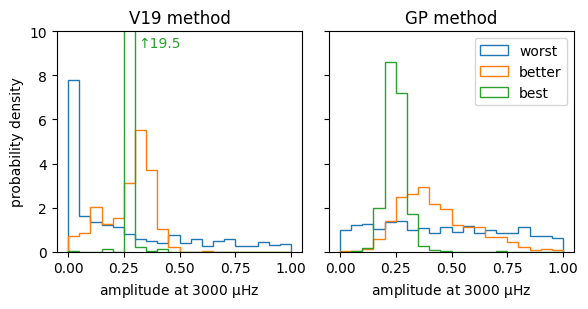

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3.2), sharex=True, sharey=True)

histtype = "step"
alpha = 1.0
density = True
ymax = 10

ax = axes[0]
for k, v in v19.items():
    param = v.iloc[:, :-2].to_numpy()
    ahe = helium_amp(param, nu_ref)
    count, bin_edges, _ = ax.hist(ahe, range=(0, 1), bins=20, histtype=histtype, alpha=alpha, density=density)
ax.set_title("V19 method")
ax.set_xlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
ax.set_ylabel("probability density")
imax = count.argmax()
xy = (1.05*bin_edges[imax+1], 0.98*ymax)
# xytext = (bin_edges[imax+4], 0.9*ymax)
# ax.annotate(f"{count[imax]:.1f}", xy=xy, xytext=xytext,
#             arrowprops=dict(arrowstyle="->"))
ax.text(*xy, f"↑{count[imax]:.1f}", verticalalignment="top", color="C2")


ax = axes[1]
for k, v in gps.items():
    ahe = model[k].helium_amp(v, nu_ref)
    ax.hist(ahe, range=(0, 1), bins=20, histtype=histtype, alpha=alpha, density=density, label=k)

ax.legend()
ax.set_title("GP method")
ax.set_ylim(top=ymax)
ax.set_xlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
# fig.supxlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
# fig.supylabel(f"count")

fig.tight_layout()
fig.savefig("../figures/glitch-test-amplitude.eps", format="eps", dpi=300)


In [66]:
from corner import corner

In [94]:
k = "better"
df_gp = pd.DataFrame(gps[k])
df_gp.head()

,delta_nu,epsilon,log_alpha_cz,log_alpha_he,log_beta_he,log_sigma,log_tau_cz,log_tau_he,phi_cz,phi_he
0,132.978577,1.398819,8.299648,-11.142146,-14.814491,-6.049212,-6.156483,-7.209647,3.301220,5.538964
1,132.646530,1.359783,8.495752,-10.966076,-15.387301,-4.837303,-6.119932,-7.551999,0.322152,0.102910
2,133.074783,1.394948,8.612399,-11.071440,-15.018761,-2.748772,-6.060854,-7.323714,1.812560,1.831242
3,133.067108,1.382257,8.575351,-10.812216,-14.903160,-3.974006,-6.087233,-7.341298,4.201250,2.346227
4,132.738312,1.408967,9.070082,-11.260752,-15.076070,-4.427960,-6.075263,-7.325948,3.458995,1.837427


In [95]:
log_cols = [col for col in df_gp.columns if col.startswith("log_")]
cols = [col[4:] for col in log_cols]

df_gp[cols] = np.exp(df_gp[log_cols])
sec_cols = ["alpha_he", "tau_he", "tau_cz"]
df_gp[sec_cols] *= 1e6

df_gp.head()

,delta_nu,epsilon,log_alpha_cz,log_alpha_he,log_beta_he,log_sigma,log_tau_cz,log_tau_he,phi_cz,phi_he,alpha_cz,alpha_he,beta_he,sigma,tau_cz,tau_he
0,132.978577,1.398819,8.299648,-11.142146,-14.814491,-6.049212,-6.156483,-7.209647,3.301220,5.538964,4022.457275,0.000014,3.682546e-07,0.002360,0.002120,0.000739
1,132.646530,1.359783,8.495752,-10.966076,-15.387301,-4.837303,-6.119932,-7.551999,0.322152,0.102910,4893.937012,0.000017,2.076729e-07,0.007928,0.002199,0.000525
2,133.074783,1.394948,8.612399,-11.071440,-15.018761,-2.748772,-6.060854,-7.323714,1.812560,1.831242,5499.426758,0.000016,3.002169e-07,0.064006,0.002332,0.000660
3,133.067108,1.382257,8.575351,-10.812216,-14.903160,-3.974006,-6.087233,-7.341298,4.201250,2.346227,5299.410156,0.000020,3.370077e-07,0.018798,0.002272,0.000648
4,132.738312,1.408967,9.070082,-11.260752,-15.076070,-4.427960,-6.075263,-7.325948,3.458995,1.837427,8691.333984,0.000013,2.834954e-07,0.011939,0.002299,0.000658


In [98]:
df_gp["delta_he"] = 1e6 * np.sqrt(df_gp["beta_he"]/8) / np.pi
df_gp["a_he"] = 1e-6 * df_gp["alpha_he"] * df_gp["delta_nu"]
df_gp["a_cz"] = df_gp["alpha_cz"] * df_gp["delta_nu"]

In [106]:
v19[k]["log_a_he"] = np.log10(v19[k]["a_he"])
df_gp["log_a_he"] = np.log10(df_gp["a_he"])
v19[k]["log_a_cz"] = np.log10(v19[k]["a_cz"])
df_gp["log_a_cz"] = np.log10(df_gp["a_cz"])

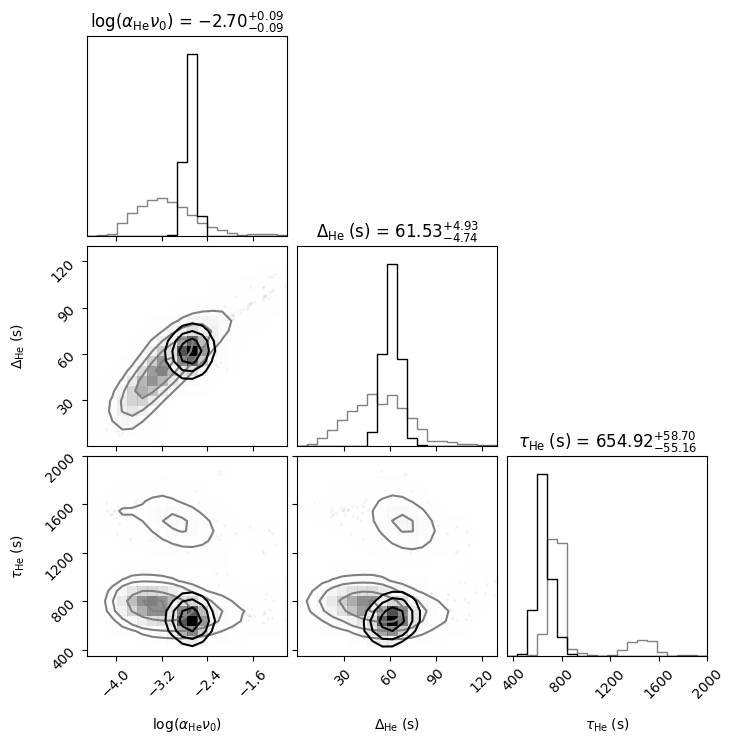

In [130]:
he_cols = ["log_a_he", "delta_he", "tau_he"]
labels = [
    r"$\log(\alpha_\mathrm{He}\nu_0)$", 
    r"$\Delta_\mathrm{He} \; (\mathrm{s})$", 
    r"$\tau_\mathrm{He} \; (\mathrm{s})$"
]
smooth = 1.1
rlim = [(-4.5, -1), (0, 130), (350, 2000)]
fig = corner(v19[k][he_cols], range=rlim, color="gray", smooth=smooth)
fig = corner(df_gp[he_cols], range=rlim, fig=fig, smooth=smooth, 
             labels=labels, show_titles=True)


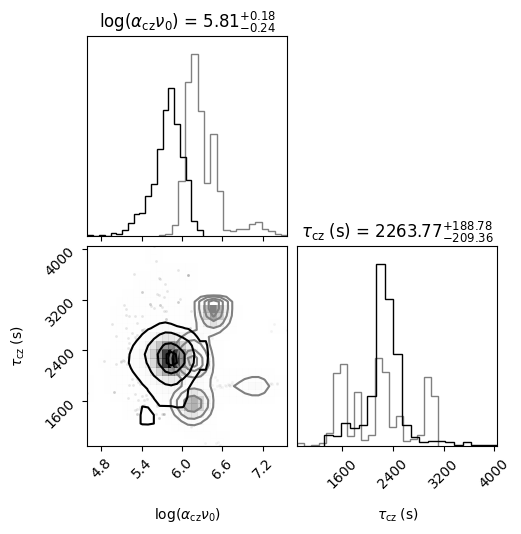

In [132]:
cz_cols = ["log_a_cz", "tau_cz"]
smooth = 1.1
labels = [
    r"$\log(\alpha_\mathrm{cz}\nu_0)$", 
    r"$\tau_\mathrm{cz} \; (\mathrm{s})$"
]

fig = corner(v19[k][cz_cols], color="gray", smooth=smooth)
fig = corner(df_gp[cz_cols], fig=fig, labels=labels, smooth=smooth, show_titles=True)

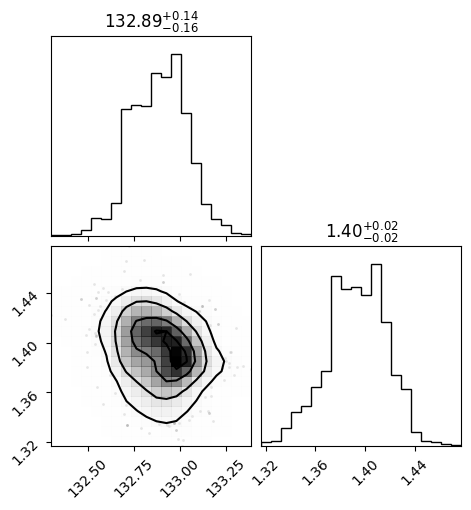

In [143]:
ccols = ["delta_nu", "epsilon"]
fig = corner(df_gp[ccols], smooth=smooth, show_titles=True)